In [584]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [585]:
class DynaQAgent:
    
    def __init__(self, agent_info):
        self.num_states = agent_info.get("num_states", 1)
        self.num_actions = agent_info.get("num_actions", 1)
        self.gamma = agent_info.get("discount", 0.95)
        self.alpha = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 0)
        
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        
        self.model = {}
        
        self.past_action = -1
        self.past_state = -1
    
    def reset(self):
        self.q_values = np.zeros((self.num_states, self.num_actions))
    
    def argmax(self, q_values):
        top = float("-inf")
        ties = []
        
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            
            if q_values[i] == top:
                ties.append(i)
        
        return np.random.choice(ties)
    
    def update_model(self, past_state, past_action, reward, state):
        key = (past_state, past_action)
        distribution = np.zeros((self.num_states, 2)) if key not in self.model else self.model[key]
        
        
        distribution[state][0] += 1
        
        count = distribution[state][0]
        current_reward = distribution[state][1]
        distribution[state][1] += (reward - current_reward) / count
        
        self.model[key] = distribution
        
    def planning_step(self):
        for i in range(self.planning_steps):
            num_keys = len(self.model.keys())
            idx = np.random.choice(num_keys)
            state, action = list(self.model.keys())[idx]
            
            distribution = self.model[(state, action)]
            prob = distribution[:,0] / np.sum(distribution[:,0])
            next_state = np.random.choice(range(self.num_states), p=prob)
            reward = distribution[next_state][1]
            
            target = reward + self.gamma * max(self.q_values[next_state])
            error = target - self.q_values[state,action]
            self.q_values[state,action] += self.alpha * error
    
    def choose_action_egreedy(self, state):
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            values = self.q_values[state]
            action = self.argmax(values)
        
        return action
    
    def start(self, state):
        self.past_state = state
        self.past_action = self.choose_action_egreedy(state)
        
        return self.past_action
    
    def step(self, reward, state):
        target = reward + self.gamma * max(self.q_values[state])
        error = target - self.q_values[self.past_state,self.past_action]
        self.q_values[self.past_state,self.past_action] += self.alpha * error
        
        self.update_model(self.past_state, self.past_action, reward, state)
        self.planning_step()
        
        self.past_state = state
        self.past_action = self.choose_action_egreedy(state)
        
        return self.past_action

In [586]:
def train_agent(agent, env, num_episodes, turn_off_exploration=False):
    rewards = []
    steps = []
    
    agent.reset()
    for ep in range(num_episodes):
        state = -1
        reward = 0
        terminated = False
        truncated = False
        step_count = 1
        
        if ep == num_episodes // 2 and turn_off_exploration:
            agent.epsilon = 0
        
        state, _ = env.reset()
        action = agent.start(state)
        while not terminated and not truncated:
            state, reward, terminated, truncated, _ = env.step(action)
            step_count += 1
            
            action = agent.step(reward, state)
        
        rewards.append(reward)
        steps.append(step_count)
    
    return steps, rewards

In [587]:
def run_experiment(agent, env, num_trials, num_episodes, turn_off_exploration=False):
    steps = []
    rewards = []
    
    for _ in tqdm(range(num_trials)):
        agent.reset()
        s, r = train_agent(agent, env, num_episodes, turn_off_exploration)
        steps.append(s)
        rewards.append(r)
    
    return steps, rewards

In [588]:
def plot_results(agent_info):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

    for agent in agent_info.keys():
        steps = np.array(agent_info[agent]['steps'])
        rewards = np.array(agent_info[agent]['rewards'])
        
        steps = np.mean(steps, axis=0)
        rewards = np.mean(rewards, axis=0)
        
        ax1.plot(steps, label=agent, linewidth=0.5, alpha=0.9)
        ax2.plot(rewards, label=agent, linewidth=1, alpha=0.5)

        fig.suptitle('Dyna-Q Agent Performance', fontsize=16)
        ax1.set_title('Average Number of Steps')
        ax2.set_title('Average Reward')
        ax1.legend()
        ax2.legend()

In [589]:
def action_grid(q, best_action=False):
    z = np.zeros((3,3))
    
    dirs = {
        0: [1,0],
        1: [2,1],
        2: [1,2],
        3: [0,1]
    }
    
    z[1,1] = q.mean()
    
    if best_action:
        x,y = dirs[np.argmax(q)]
        z[x,y] = q.max()
       
    else:
        for i in range(len(q)):
            x,y = dirs[i]
            z[x,y] = q[i]   
    return z

def status_grid(q, best_action=False, size=4):
    rows = []
    for i in range(size):
        cols = []
        for j in range(size):
            cols.append(action_grid(q[i*size+j], best_action))
        rows.append(np.concatenate(cols, axis=1))
    return np.concatenate(rows, axis=0)

def show_grid(ax, q, best_action=False, size=4):

    g = status_grid(q, best_action, size)
    ax.imshow(g)

    # draw a line through the middle
    for i in range(1, size):
        ax.axhline(i*3 - 0.5 , color='w', linewidth=2)
        ax.axvline(i*3 - 0.5, color='w', linewidth=2)
    
    ax.axis('off')

# Prueba sin Slippery 🤷‍♂️

In [590]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

agent_p0 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 0
})

agent_p2 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 2
})

agent_p5 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 5
})

agents = {
    'agent_p0': { 'agent': agent_p0, 'steps': [], 'rewards': [] },
    'agent_p2': { 'agent': agent_p2, 'steps': [], 'rewards': [] },
    'agent_p5': { 'agent': agent_p5, 'steps': [], 'rewards': [] }
}

In [591]:
for agent in agents.keys():
    s, r = run_experiment(agents[agent]['agent'], env, 1000, 300)
    agents[agent]['steps'] = s
    agents[agent]['rewards'] = r

100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]


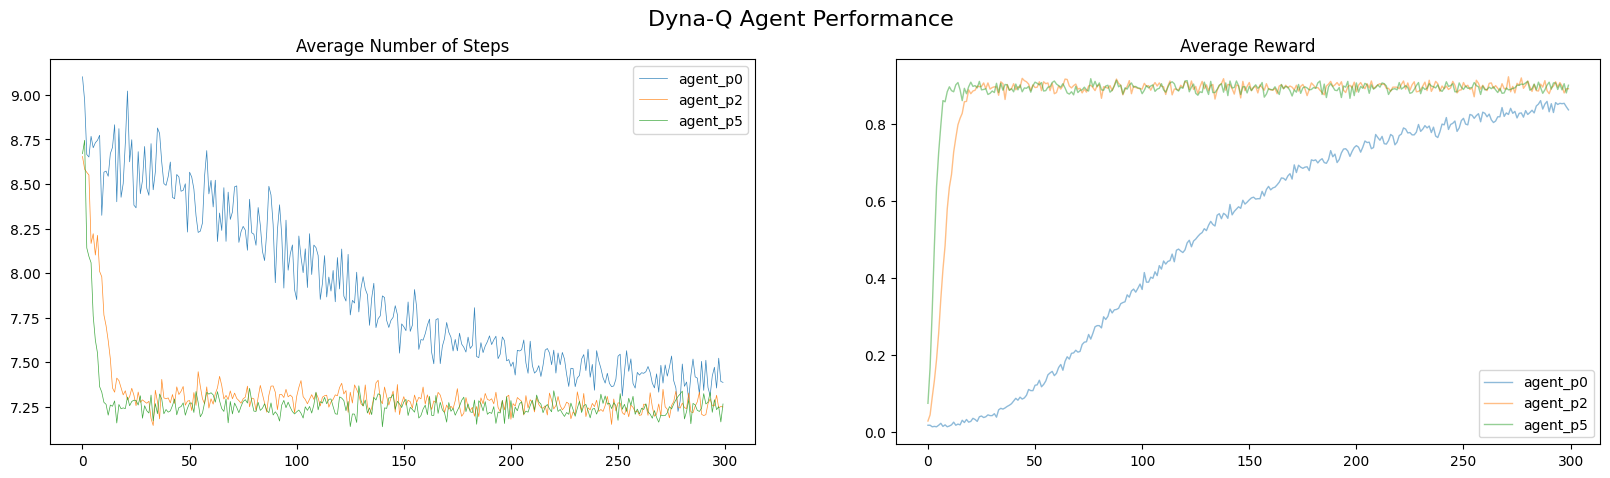

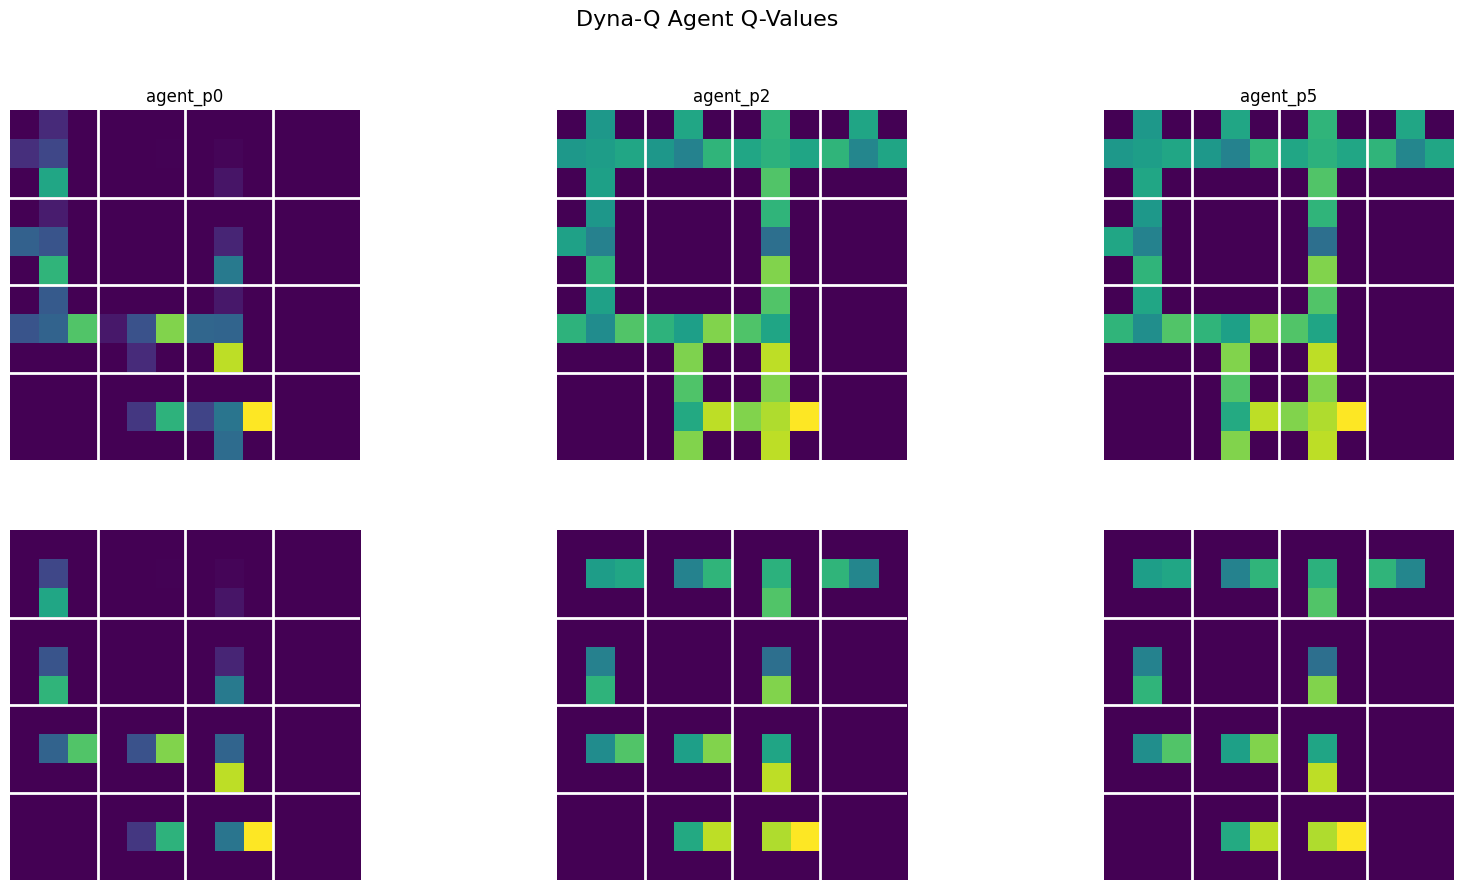

In [592]:
plot_results(agents)

fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Dyna-Q Agent Q-Values', fontsize=16)
for i, agent in enumerate(agents.keys()):
    axs[0,i].set_title(agent)
    show_grid(axs[0,i], agents[agent]['agent'].q_values, best_action=False, size=4)
    show_grid(axs[1,i], agents[agent]['agent'].q_values, best_action=True, size=4)

# Prueba con Slippery ⛸

In [593]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

agent_p0 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 0
})

agent_p2 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 2
})

agent_p5 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 5
})

agents = {
    'agent_p0': { 'agent': agent_p0, 'steps': [], 'rewards': [] },
    'agent_p2': { 'agent': agent_p2, 'steps': [], 'rewards': [] },
    'agent_p5': { 'agent': agent_p5, 'steps': [], 'rewards': [] }
}

In [594]:
for agent in agents.keys():
    s, r = run_experiment(agents[agent]['agent'], env, 1000, 300)
    agents[agent]['steps'] = s
    agents[agent]['rewards'] = r

100%|██████████| 1000/1000 [09:13<00:00,  1.81it/s]


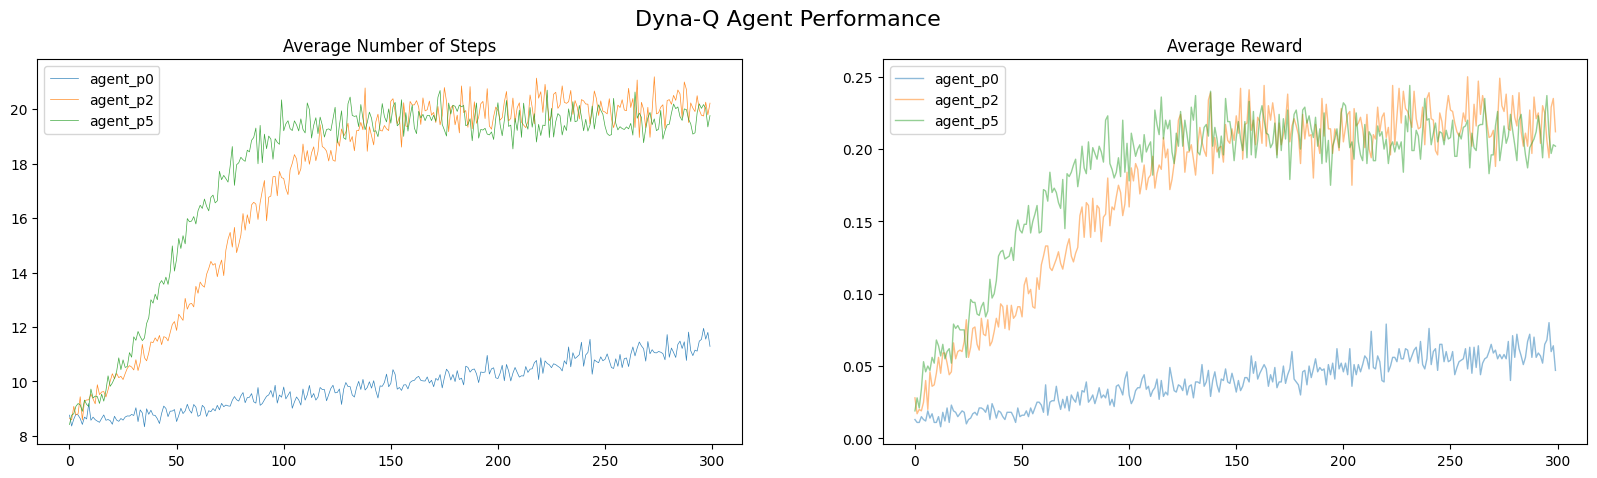

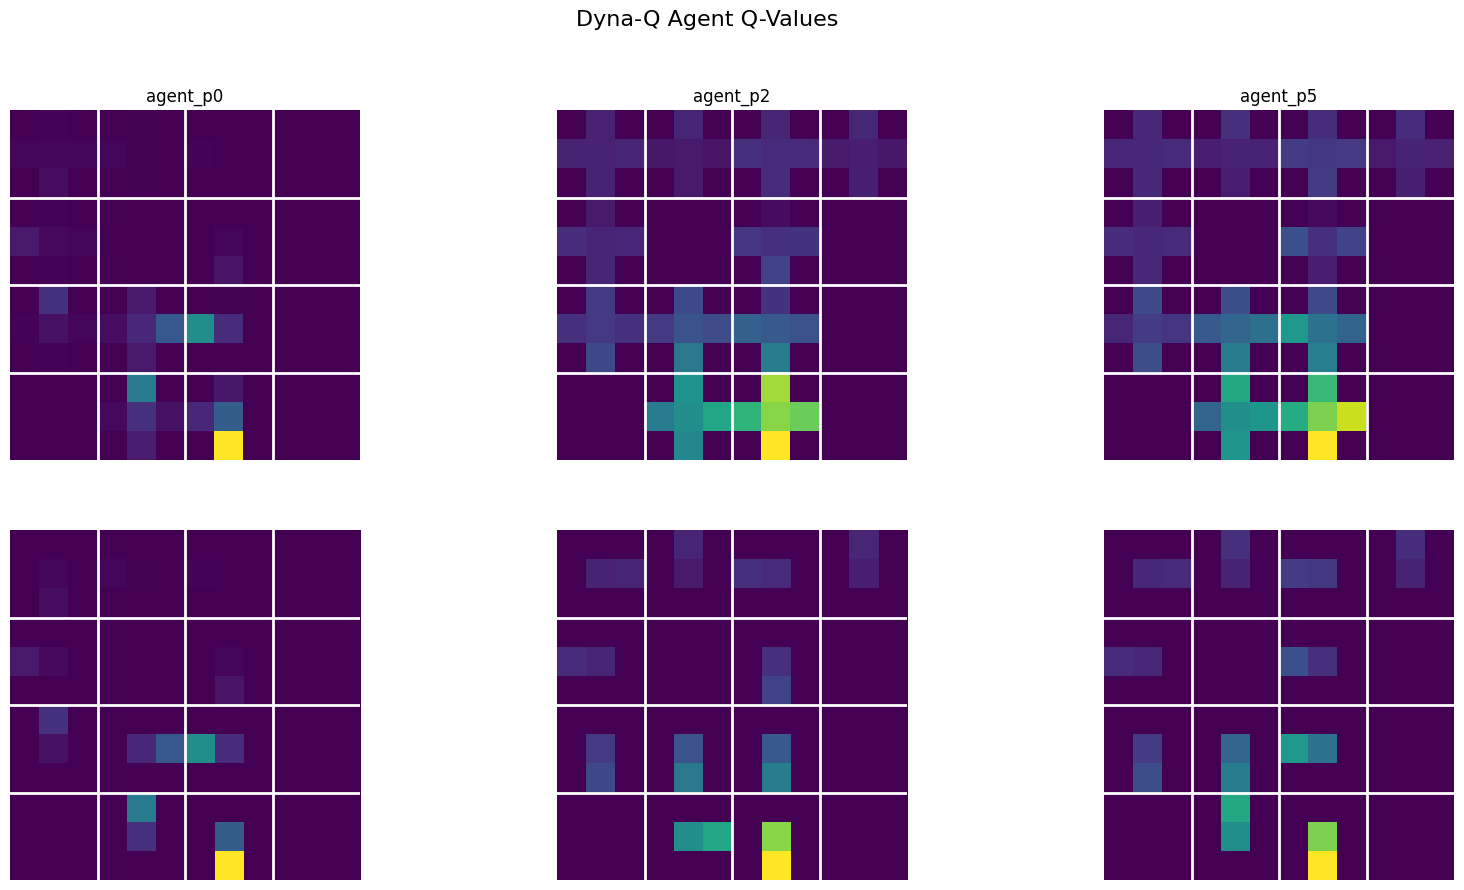

In [595]:
plot_results(agents)

fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Dyna-Q Agent Q-Values', fontsize=16)
for i, agent in enumerate(agents.keys()):
    axs[0,i].set_title(agent)
    show_grid(axs[0,i], agents[agent]['agent'].q_values, best_action=False, size=4)
    show_grid(axs[1,i], agents[agent]['agent'].q_values, best_action=True, size=4)

# Lets go for a biggerrr grid 🥵 (with no slippery)

In [596]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False)

agent_p0 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 0
})

agent_p2 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 2
})

agent_p5 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.9,
    "planning_steps": 5
})

agents = {
    'agent_p0': { 'agent': agent_p0, 'steps': [], 'rewards': [] },
    'agent_p2': { 'agent': agent_p2, 'steps': [], 'rewards': [] },
    'agent_p5': { 'agent': agent_p5, 'steps': [], 'rewards': [] }
}

In [597]:
for agent in agents.keys():
    s, r = run_experiment(agents[agent]['agent'], env, 1000, 500)
    agents[agent]['steps'] = s
    agents[agent]['rewards'] = r

100%|██████████| 1000/1000 [15:05<00:00,  1.10it/s]


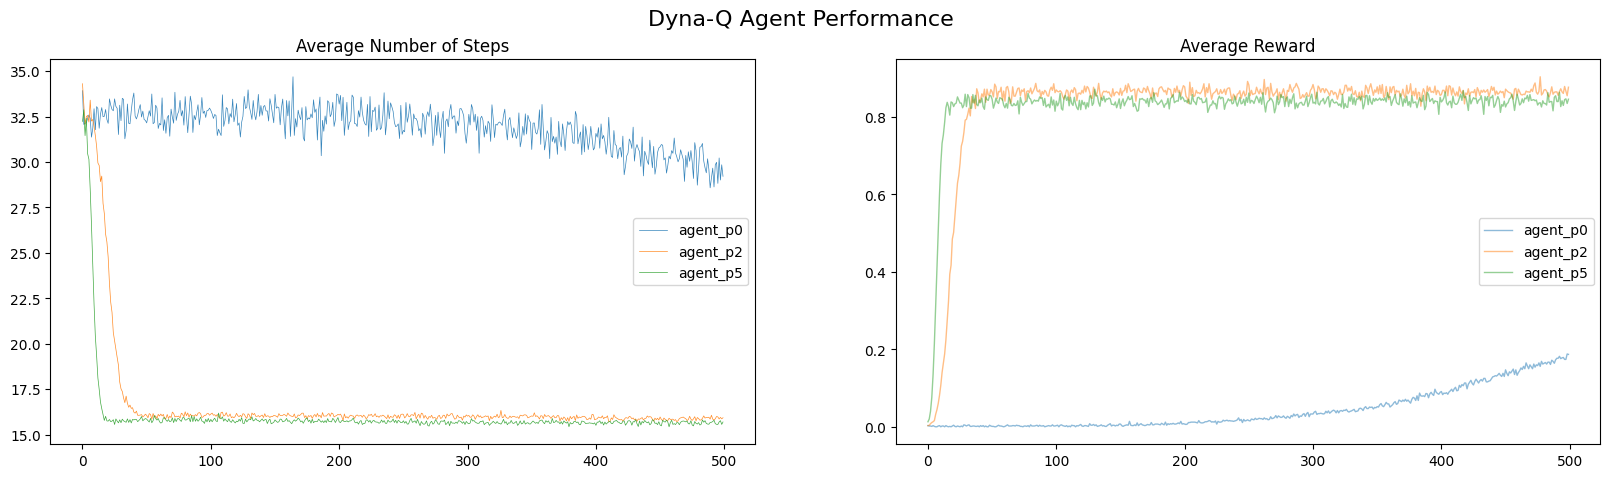

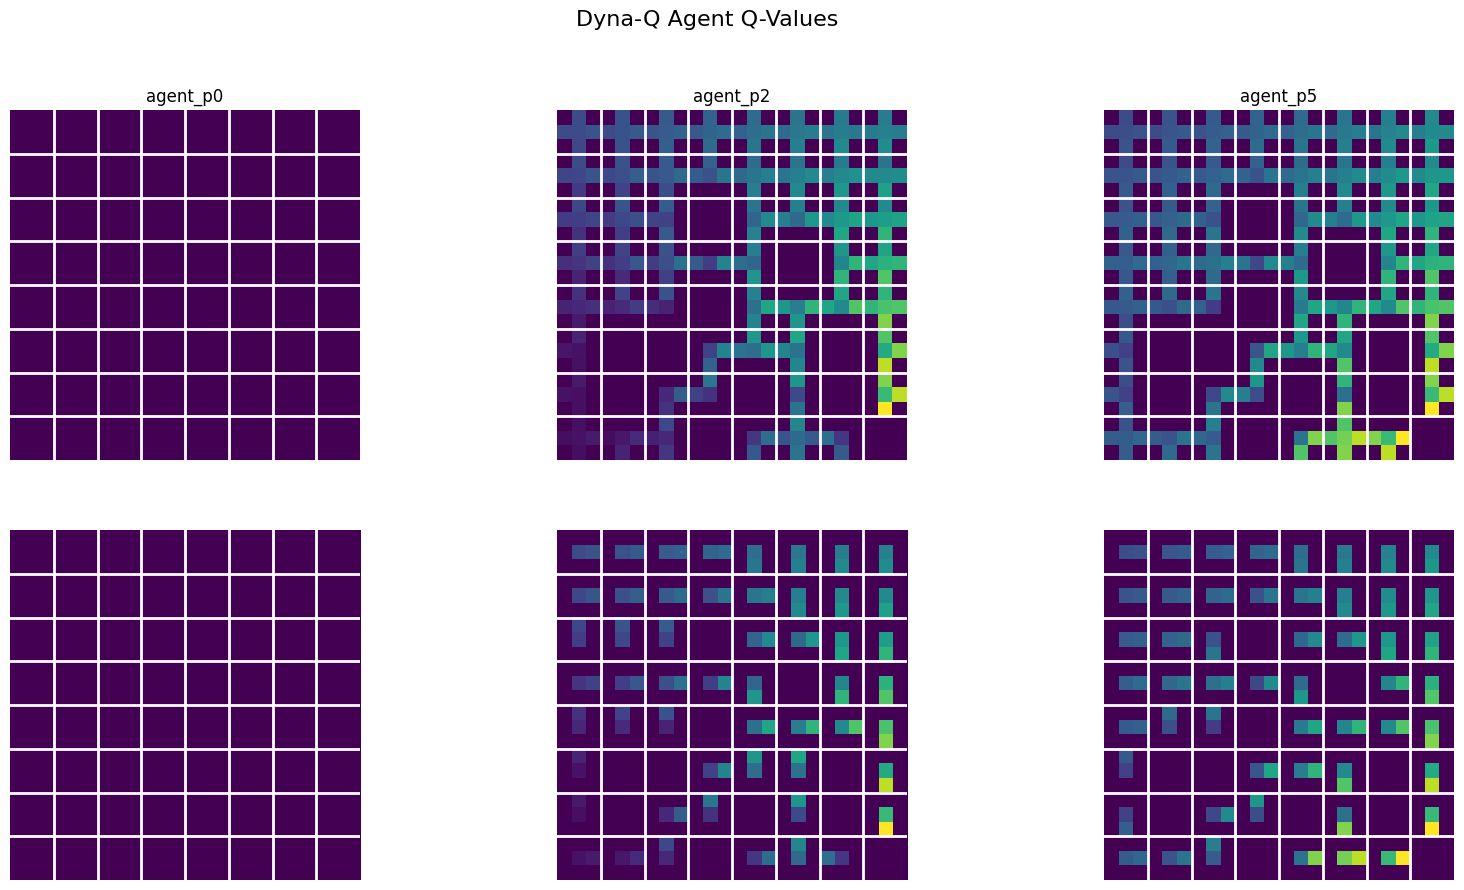

In [598]:
plot_results(agents)

fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Dyna-Q Agent Q-Values', fontsize=16)
for i, agent in enumerate(agents.keys()):
    axs[0,i].set_title(agent)
    show_grid(axs[0,i], agents[agent]['agent'].q_values, best_action=False, size=8)
    show_grid(axs[1,i], agents[agent]['agent'].q_values, best_action=True, size=8)

# biggerrr grid with slippery ☠️

In [599]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True)

agent_p0 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.975,
    "planning_steps": 0
})

agent_p2 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.975,
    "planning_steps": 2
})

agent_p5 = DynaQAgent({
    "num_actions": env.action_space.n,
    "num_states": env.observation_space.n,
    "discount": 0.975,
    "planning_steps": 5
})

agents = {
    'agent_p0': { 'agent': agent_p0, 'steps': [], 'rewards': [] },
    'agent_p2': { 'agent': agent_p2, 'steps': [], 'rewards': [] },
    'agent_p5': { 'agent': agent_p5, 'steps': [], 'rewards': [] }
}

In [ ]:
for agent in agents.keys():
    s, r = run_experiment(agents[agent]['agent'], env, 1000, 800)
    agents[agent]['steps'] = s
    agents[agent]['rewards'] = r

In [605]:
s, r = run_experiment(agents['agent_p5']['agent'], env, 100, 800)
agents['agent_p5']['steps'] = s
agents['agent_p5']['rewards'] = r

100%|██████████| 100/100 [09:03<00:00,  5.43s/it]


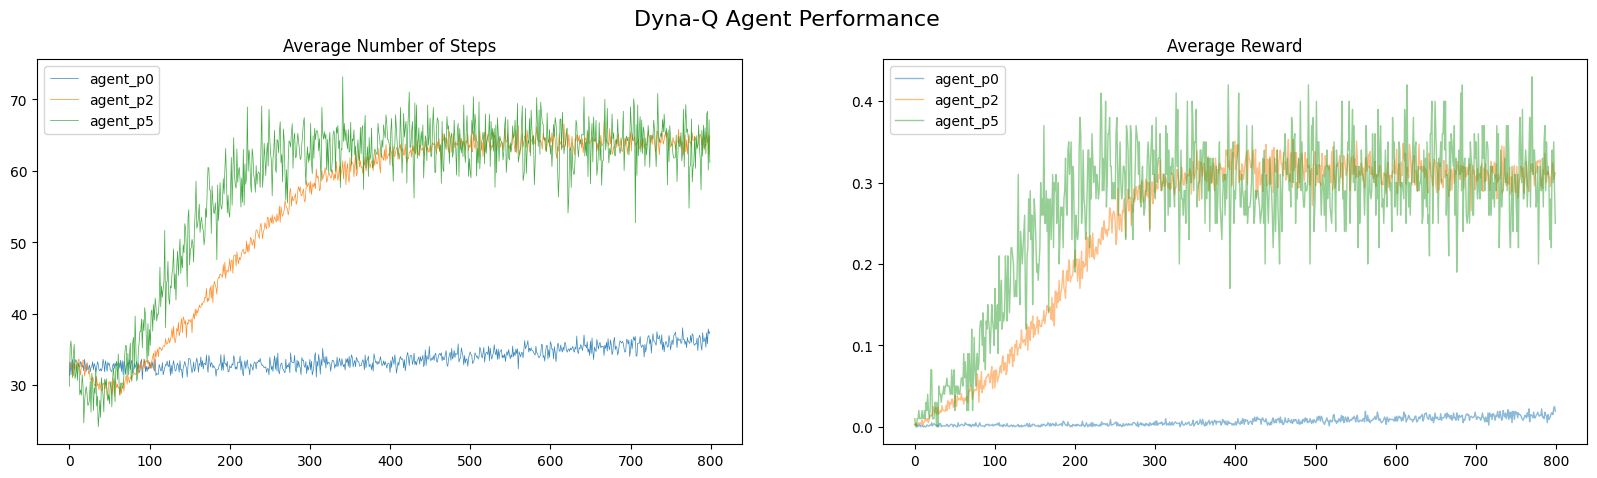

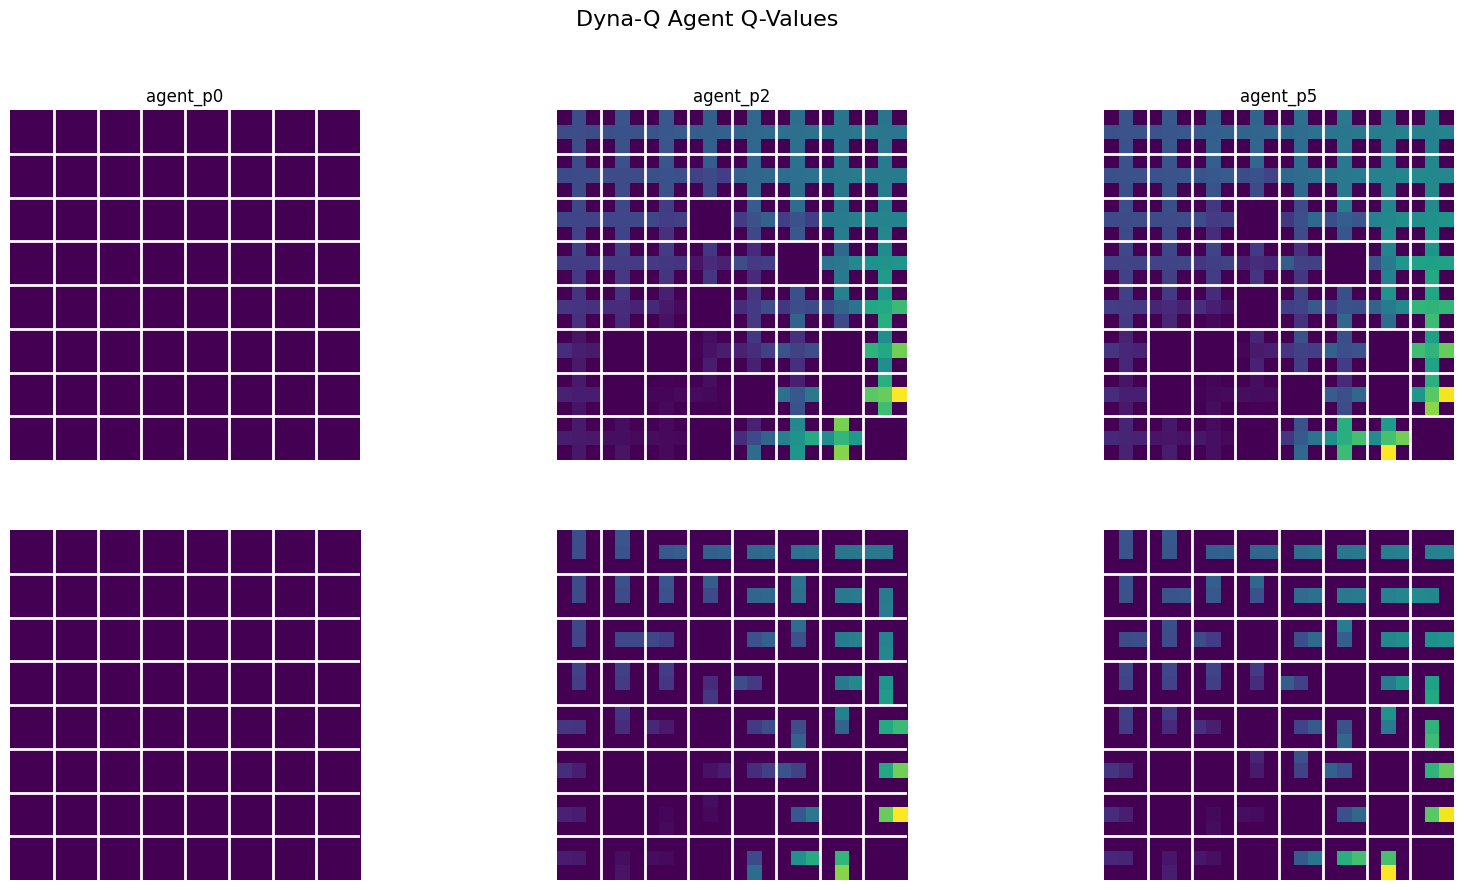

In [606]:
plot_results(agents)

fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.suptitle('Dyna-Q Agent Q-Values', fontsize=16)
for i, agent in enumerate(agents.keys()):
    axs[0,i].set_title(agent)
    show_grid(axs[0,i], agents[agent]['agent'].q_values, best_action=False, size=8)
    show_grid(axs[1,i], agents[agent]['agent'].q_values, best_action=True, size=8)